# 4. Putting together likelihood and priors

Here we just want to bring together the functions that we have in various places, and test the functionality.

In [1]:
import sys, os
sys.path.append("..")

from inverse import bayesian_funcs as bf
from inverse import priors as pr
from preprocess import preprocess as pp
from preprocess import permute
from brain import Brain
from utils import path as pth
from utils import functions

In [63]:
#generic modules
import matplotlib.pyplot as mpl
%matplotlib inline
from scipy.io import loadmat
import numpy as np
from scipy import stats
import math

In [3]:
FMEG_path = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/data/freqMEGdata.mat' #insert appropriate path here.
label_filepath = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/atlases/OrderingAlphabetical_68ROIs.txt'
data = loadmat(FMEG_path)
pat1 = data['freqMEGdata'][0][0][0]

In [4]:
pat1_dict = pp.add_key_to_matdata(label_filepath, pat1)

In [5]:
orderfile = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/atlases/HCP_list.h5'
FMEGdownsample = permute.order_dict(pat1_dict, orderfile)

In [6]:
fmin = 2 # 2Hz - 45Hz signal range
fmax = 45
fvec = np.linspace(fmin,fmax,40)

In [7]:
newbrain = Brain.Brain()
hcp_dir = pth.get_sibling_path('data') # connectome information is in /data/ dir
newbrain.add_connectome(hcp_dir) # Use default files in /data/
newbrain.reorder_connectome(newbrain.connectome, newbrain.distance_matrix)
newbrain.bi_symmetric_c()
newbrain.reduce_extreme_dir()

In [12]:
params = []
ntf_params = {'tau_e':0.008,
                           'tau_i':0.008,
                           'alpha':1.0,
                           'speed':9.0,
                           'gei':5.0,
                           'gii':1.5,
                           'tauC':0.006
                           }
for key, value in ntf_params.items():
    temp = [key,value]
    params.append(value)

In [90]:
params

[0.008, 0.008, 1.0, 9.0, 5.0, 1.5, 0.006]

In [13]:
param_dists = {'tau_e':{'type':'gamma','alpha':2, 'loc':0.004492887509221829, 'scale':0.0032375996670863947},
    'tau_i':{'type':'gamma','alpha':2.006014687419703, 'loc':0.004662441067103153, 'scale':0.0025497764353055712},
              'alpha':{'type':'uniform','lower':0, 'upper':5},
              'speed':{'type':'uniform','lower':0, 'upper':25},
              'gei':{'type':'uniform','lower':0, 'upper':10},
              'gii':{'type':'uniform','lower':0, 'upper':10},
              'tauC':{'type':'gamma','alpha':2, 'loc':0.004211819821836749, 'scale':0.0029499360144432463}}

In [14]:
triallikelihood = bf.ln_likelihood_pearson(params, newbrain, fvec, FMEGdownsample)

In [15]:
triallikelihood

-33.73993950679045

In [16]:
neg_lnprior, priorlist = pr.lnpriors(params, param_dists)

In [17]:
neg_lnprior

3.1507073745035754

## Total ln(probability) function

Annoyingly, currently have things set up so that the ntf model accepts the dictionary version of params, while the prior distribution is set up to take an array (which is more in keeping with how MCMC we are going to use works). So, we need to include a conversion to dictionary at the appropriate point in the ln_likelihood_pearson function.

In [64]:
def lnprobs(theta, param_dists, brain, fvec, data):
    print(theta)
    neg_lnprior = lnpriors(theta, param_dists)
    if not np.isfinite(neg_lnprior):
        return -np.inf
    return neg_lnprior + ln_likelihood_pearson(theta, brain, fvec, data)

In [65]:
lnprobs(params, param_dists, newbrain, fvec, FMEGdownsample)

[0.008, 0.008, 1.0, 9.0, 5.0, 1.5, 0.006]


-30.589232132286874

To make sure I can thoroughly debug stuff as I try to apply MCMC I am going to directly define the functions here:

In [1]:
def lnprior_gamma(value, key, param_dists):
    tau = value
    x = (tau - param_dists[key]['loc'])/param_dists[key]['scale']
    p = stats.gamma.pdf(x, param_dists[key]['alpha'])
    p = p.astype(float)
    if p == 0:
        return -np.inf #use the same as for outside uniform distribution bounds
    return math.log(p)

In [67]:
def lnprior_uniform(value, key, param_dists):
    if param_dists[key]['lower'] < value < param_dists[key]['upper']:
        return 0.0
    return -np.inf

Also going to define lnpriors function in a very explicit way for debugging purposes.

In [68]:
def lnpriors(theta, param_dists):
    tau_e, tau_i, alpha, speed, gei, gii, tauC = theta
    
    lnp_taue = lnprior_gamma(tau_e, 'tau_e', param_dists)
    lnp_taui = lnprior_gamma(tau_i, 'tau_i', param_dists)
    lnp_alpha = lnprior_uniform(alpha, 'alpha', param_dists)
    lnp_speed = lnprior_uniform(speed, 'speed', param_dists)
    lnp_gei = lnprior_uniform(gei, 'gei', param_dists)
    lnp_gii = lnprior_uniform(gii, 'gii', param_dists)
    lnp_tauC = lnprior_gamma(tauC, 'tauC', param_dists)
    
    return lnp_taue + lnp_taui + lnp_alpha+lnp_speed+lnp_gei+lnp_gii+lnp_tauC

Let's also make sure we have a very explicit likelihood function (for now)

In [69]:
from inverse import cost
from forward import runforward as rf
def ln_likelihood_pearson(theta, brain, fvec, FMEGdata):
    tau_e, tau_i, alpha, speed, gei, gii, tauC = theta
    #First need to convert parameter array to dictionary required by the run_forward func.
    if type(theta) != dict:
        parameters = {'tau_e':tau_e,
                       'tau_i':tau_i,
                       'alpha':alpha,
                       'speed':speed,
                       'gei':gei,
                       'gii':gii,
                       'tauC':tauC
                       }
    else:
        parameters = theta

    #first, run the ntf model for this setting of parameters
    freq_model = rf.run_forward(brain, parameters, fvec)

    #now calculate the pearson r based error
    errors, list_errors = cost.pearson_cost_oneminus(FMEGdata, freq_model)

    list_errors = np.asarray(list_errors)

    #calculate the total negative lnlikelihood based on the errors of the pearson cost function
    return -0.5*(np.sum(list_errors))

# MCMC 

No idea if this will even run (it probably won't) but it is time to give it a go:

In [70]:
import emcee

In [71]:
pos = params #start with the random(ish) point we picked above

In [72]:
ndim, nwalkers = 7, 16

In [73]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobs, args=(param_dists, newbrain, fvec,FMEGdownsample))

In [74]:
pos = [params + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] #starting position in parameter space.

In [92]:
pos[0]

array([7.99751574e-03, 7.99748421e-03, 9.99862288e-01, 9.00019409e+00,
       4.99992285e+00, 1.50000554e+00, 6.03536414e-03])

In [75]:
sampler.run_mcmc(pos, 50);

[7.99751574e-03 7.99748421e-03 9.99862288e-01 9.00019409e+00
 4.99992285e+00 1.50000554e+00 6.03536414e-03]
[7.84615211e-03 7.94583905e-03 1.00013606e+00 8.99987221e+00
 4.99985356e+00 1.50016805e+00 6.15698360e-03]
[8.00951702e-03 7.95124708e-03 9.99961840e-01 8.99983278e+00
 4.99975443e+00 1.49987386e+00 5.98178188e-03]
[7.87458248e-03 7.83403636e-03 9.99896144e-01 8.99994202e+00
 4.99999863e+00 1.50025912e+00 5.98203289e-03]
[7.98725145e-03 8.03900207e-03 1.00009108e+00 8.99993405e+00
 5.00006382e+00 1.50004594e+00 6.07920869e-03]
[8.01368566e-03 8.00052888e-03 1.00003702e+00 8.99994993e+00
 4.99995759e+00 1.50014736e+00 6.07690795e-03]
[8.04144543e-03 8.03620303e-03 1.00011531e+00 8.99976545e+00
 5.00017091e+00 1.49987290e+00 5.93994545e-03]
[7.85382140e-03 7.92284024e-03 1.00023472e+00 9.00003200e+00
 5.00008425e+00 1.50009229e+00 6.08417316e-03]
[8.08615591e-03 8.07105660e-03 9.99941358e-01 8.99986261e+00
 4.99989991e+00 1.50016285e+00 6.04978322e-03]
[8.00065185e-03 8.15724631e-

In [76]:
sampler.chain.shape

(16, 50, 7)

In [81]:
time = np.arange(1,50)
len(time)

49

Text(0,0.5,'tau_e')

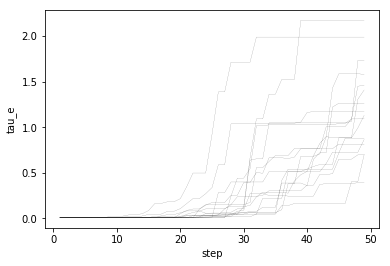

In [82]:
time = np.arange(1,50)
for i in range(sampler.chain.shape[0]):
    mpl.plot(time, sampler.chain[i,:49,0], linewidth = 0.1, color = 'black')

ax3 = mpl.gca()
ax3.set_xlabel('step')
ax3.set_ylabel('tau_e')

Text(0,0.5,'tau_i')

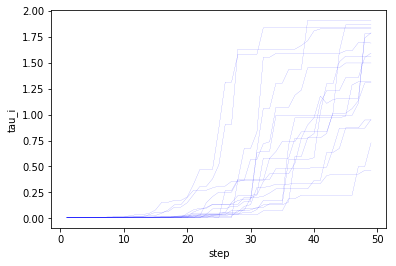

In [86]:
time = np.arange(1,50)
for i in range(sampler.chain.shape[0]):
    mpl.plot(time, sampler.chain[i,:49,1], linewidth = 0.1, color = 'blue')

ax3 = mpl.gca()
ax3.set_xlabel('step')
ax3.set_ylabel('tau_i')

Hmmm. So far this is not boding terribly well. Let's just have a go at running for a bit longer.

In [87]:
ndim, nwalkers = 7, 100

In [88]:
sampler.run_mcmc(pos, 100);

[7.99751574e-03 7.99748421e-03 9.99862288e-01 9.00019409e+00
 4.99992285e+00 1.50000554e+00 6.03536414e-03]
[7.84615211e-03 7.94583905e-03 1.00013606e+00 8.99987221e+00
 4.99985356e+00 1.50016805e+00 6.15698360e-03]
[8.00951702e-03 7.95124708e-03 9.99961840e-01 8.99983278e+00
 4.99975443e+00 1.49987386e+00 5.98178188e-03]
[7.87458248e-03 7.83403636e-03 9.99896144e-01 8.99994202e+00
 4.99999863e+00 1.50025912e+00 5.98203289e-03]
[7.98725145e-03 8.03900207e-03 1.00009108e+00 8.99993405e+00
 5.00006382e+00 1.50004594e+00 6.07920869e-03]
[8.01368566e-03 8.00052888e-03 1.00003702e+00 8.99994993e+00
 4.99995759e+00 1.50014736e+00 6.07690795e-03]
[8.04144543e-03 8.03620303e-03 1.00011531e+00 8.99976545e+00
 5.00017091e+00 1.49987290e+00 5.93994545e-03]
[7.85382140e-03 7.92284024e-03 1.00023472e+00 9.00003200e+00
 5.00008425e+00 1.50009229e+00 6.08417316e-03]
[8.08615591e-03 8.07105660e-03 9.99941358e-01 8.99986261e+00
 4.99989991e+00 1.50016285e+00 6.04978322e-03]
[8.00065185e-03 8.15724631e-

Text(0,0.5,'tau_e')

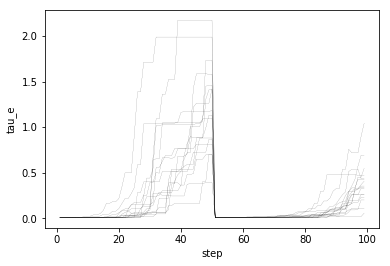

In [89]:
time = np.arange(1,100)
for i in range(sampler.chain.shape[0]):
    mpl.plot(time, sampler.chain[i,:99,0], linewidth = 0.1, color = 'black')

ax3 = mpl.gca()
ax3.set_xlabel('step')
ax3.set_ylabel('tau_e')

Hmmm. Oh dear. This may well be a problem with our likelihood function, and needs further investigation. Basically, it is (as expected from previous plots of the likelihood calculated using the pearson correlation function) optimising towards higher and higher tau, then running in to a boundary when the prior distribution makes the value very unlikely, and proceeding in that way. 

So, to get anything sensible out of this we are going to need to investigate the likelihood function more thoroughly.